In [2]:
import torch
import seaborn as sns
from pyro.distributions import transforms as T
import pyro.distributions as dist
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

In [3]:
dataset = torch.cat([torch.randn(64), torch.randn(8) + 6])[:, None]

dataset = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')
dataset = torch.from_numpy(dataset['m1']).float()
# dataset= dataset.log()
# dataset = dataset.mean(1, keepdim=True)
dataset = (dataset - dataset.mean()) / dataset.std()





<AxesSubplot:ylabel='Count'>

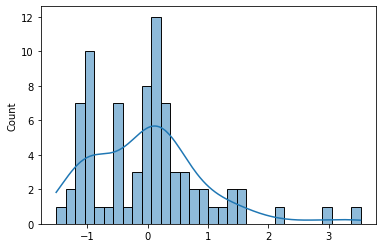

In [10]:
sns.histplot(dataset.mean(1), kde=True, bins=32)


<AxesSubplot:ylabel='Density'>

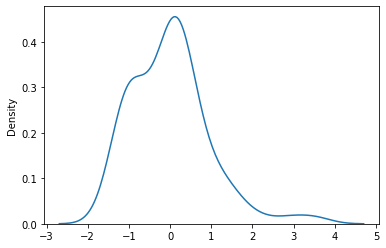

In [11]:
sns.kdeplot(dataset.mean(1).squeeze())

In [12]:
d = 1
n_layers = 6

step: 0, loss: 3.1112146377563477


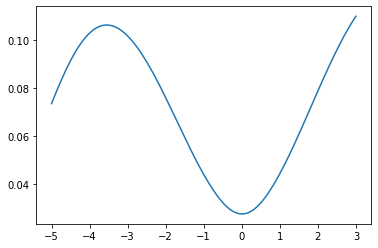

step: 8, loss: 3.015496253967285


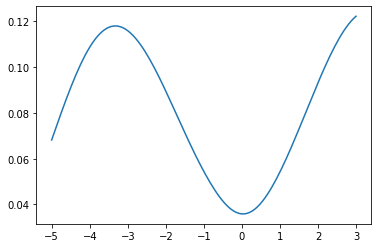

step: 16, loss: 2.8151745796203613


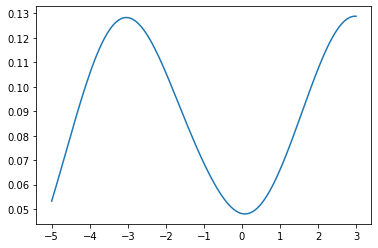

step: 24, loss: 2.72700572013855


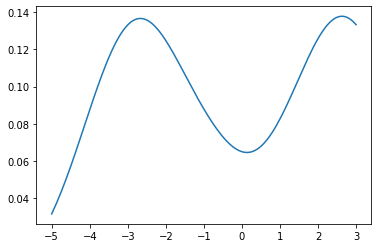

step: 32, loss: 2.2795608043670654


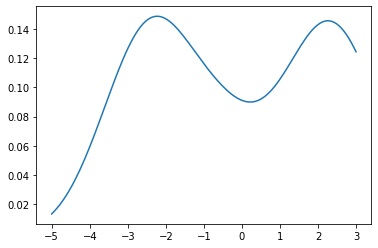

step: 40, loss: 1.995283603668213


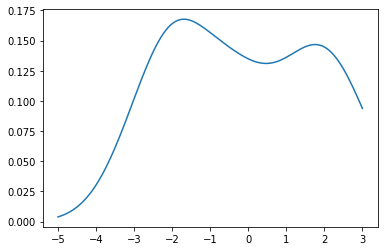

step: 48, loss: 1.64506196975708


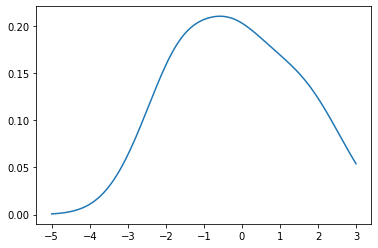

step: 56, loss: 1.4383997917175293


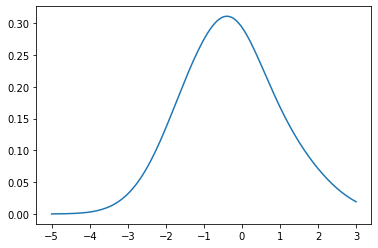

step: 64, loss: 1.9349828958511353


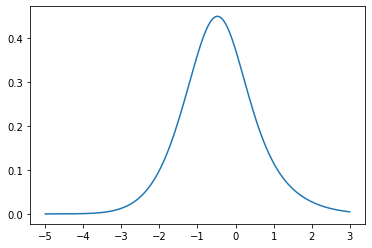

step: 72, loss: 1.4659018516540527


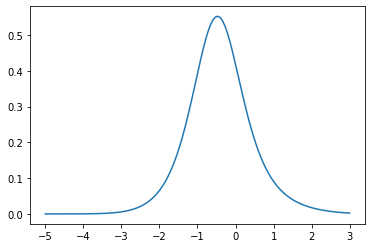

step: 80, loss: 1.238194465637207


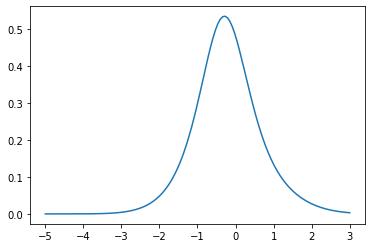

step: 88, loss: 1.574178695678711


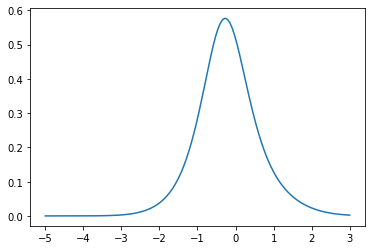

step: 96, loss: 1.0509624481201172


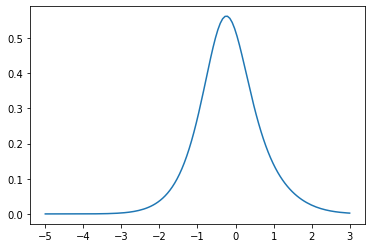

step: 104, loss: 0.8792765140533447


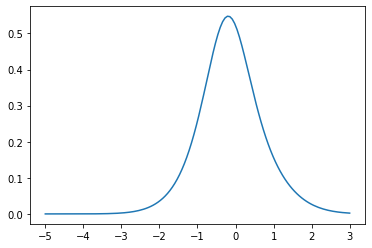

KeyboardInterrupt: 

In [13]:
transforms = nn.ModuleList([T.planar(d) for _ in range(n_layers)])
# transforms = nn.ModuleList([T.sylvester(d, count_transforms=2) for _ in range(n_layers)])
# transforms = nn.ModuleList([T.radial(d) for _ in range(n_layers)])
# transforms = nn.ModuleList([T.block_autoregressive(d) for _ in range(n_layers)])
# transforms = nn.ModuleList([T.neural_autoregressive(d) for _ in range(n_layers)])
# transforms = nn.ModuleList([T.affine_autoregressive(d) for _ in range(n_layers)])
# transforms = nn.ModuleList([T.affine_coupling(d) for _ in range(n_layers)])

base_dist = dist.Normal(0, 1)

def log_prob(x, transforms, base_dist):
    x= x.clone()
    J = 0
    for t in transforms:
        y = t(x)
        J += t.log_abs_det_jacobian(x, y)
        x = y
    log_prob = base_dist.log_prob(x).squeeze() + J
    return log_prob, y

batch_size = 4
steps = 8192
optimizer = torch.optim.Adam(transforms.parameters(), lr=1e-2)


for step in range(steps+1):
    optimizer.zero_grad()
    
    batch = dataset[torch.randperm(len(dataset))][:batch_size]
#     lp, y = log_prob(dataset, transforms, base_dist)
    lp, y = log_prob(batch.view(-1, 1), transforms, base_dist)
    lp = lp.view(batch.shape)
    
    lp = torch.logsumexp(lp, dim=-1) - math.log(lp.shape[-1])    
    loss = -lp.mean()
#     loss = -log_prob(flow_dist, dataset).mean()
    loss.backward()
    optimizer.step()
    
    
    
    if step % 8 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        with torch.no_grad():
            x = torch.linspace(-5, 3, 128)[:, None]
            lp, y = log_prob(x, transforms, base_dist)

            plt.plot(x.squeeze(), lp.exp().squeeze())
            plt.show()




In [ ]:
sum(p.numel() for p in transforms.parameters())

In [ ]:
# dataset_2d = torch.cat([torch.randn(64), torch.randn(8) + 6])
# dataset_2d = torch.stack([dataset_2d, dataset_2d + torch.randn_like(dataset_2d)], dim=-1)

dataset = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')
dataset_2d = torch.stack([torch.tensor(dataset['m1']), torch.tensor(dataset['m2'])], dim=-1).float()
dataset_2d = dataset_2d.mean(dim=1)

dataset_2d = (dataset_2d - dataset_2d.mean(dim=0, keepdim=True)) / dataset_2d.std(dim=0, keepdim=True)

sns.histplot(x=dataset_2d[:, 0], y=dataset_2d[:, 1], bins=32)
sns.kdeplot(x=dataset_2d[:, 0], y=dataset_2d[:, 1])




In [ ]:

d = 2
n_layers = 12

transforms = []
for _ in range(n_layers):
    transforms.append(T.planar(d))
    transforms.append(T.permute(d, permutation=torch.tensor([1, 0])))
transform_modules = nn.ModuleList([m for m in transforms if isinstance(m, nn.Module)])

base_dist = dist.Normal(0, 1)

def log_prob(x, transforms, base_dist):
    x= x.clone()
    J = 0
    for t in transforms:
#         print(x.shape)
        y = t(x)
        J += t.log_abs_det_jacobian(x, y)
        x = y
        
    log_prob = base_dist.log_prob(x).sum(-1) + J
    return log_prob, y

batch_size = 4
steps = 8192
optimizer = torch.optim.Adam(transform_modules.parameters(), lr=1e-2)
for step in range(steps+1):
    optimizer.zero_grad()
    
    batch = dataset_2d[torch.randperm(len(dataset_2d))][:batch_size]
#     print(dataset_2d.shape)
    lp, y = log_prob(dataset_2d, transforms, base_dist)
#     lp, y = log_prob(batch.view(-1, 1), transforms, base_dist)
#     lp = lp.view(batch.shape)
#     lp = torch.logsumexp(lp, dim=-1) - math.log(lp.shape[-1])    

    loss = -lp.mean()
#     loss = -log_prob(flow_dist, dataset_2d).mean()
    loss.backward()
    optimizer.step()
    
    
    
    if step % 8 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        with torch.no_grad():
            x = torch.linspace(-5, 5, 128)
            xx, yy = torch.meshgrid(x, x, indexing='xy')
            grid = torch.stack([xx, yy]).view(d, -1).permute(1, 0)
            lp, y = log_prob(grid, transforms, base_dist)
            p = lp.exp().view(128, 128)
            plt.imshow(p, extent=(-5, 5, -5, 5), origin='lower')
            plt.show()
            
            plt.plot(p.sum(0))
            plt.show()
            plt.plot(p.sum(1))
            plt.show()



In [34]:
# dataset_2d = torch.cat([torch.randn(64), torch.randn(8) + 6])
# dataset_2d = torch.stack([dataset_2d, dataset_2d + torch.randn_like(dataset_2d)], dim=-1)

dataset = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')
dataset_2d = torch.stack([torch.tensor(dataset['m1']), torch.tensor(dataset['m2'])], dim=-1).float()

dataset_2d = (dataset_2d - dataset_2d.mean(dim=(0, 1), keepdim=True)) / dataset_2d.std(dim=(0, 1), keepdim=True)

sns.histplot(x=dataset_2d.mean(1)[:, 0], y=dataset_2d.mean(1)[:, 1], bins=32)
sns.kdeplot(x=dataset_2d.mean(1)[:, 0], y=dataset_2d.mean(1)[:, 1])





SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (1278759512.py, line 6)

step: 0, loss: 4.341830253601074


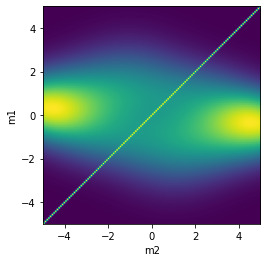

step: 8, loss: 3.664137840270996


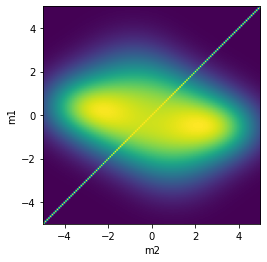

step: 16, loss: 3.164754867553711


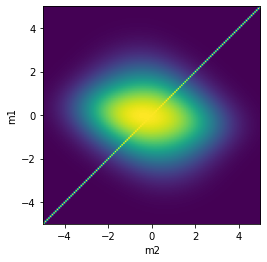

step: 24, loss: 2.7257189750671387


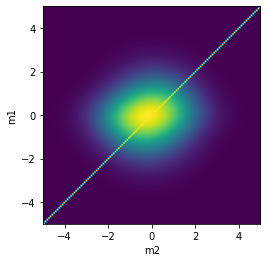

step: 32, loss: 2.7989625930786133


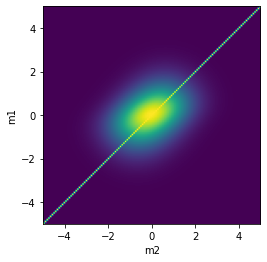

step: 40, loss: 1.9500489234924316


KeyboardInterrupt: 

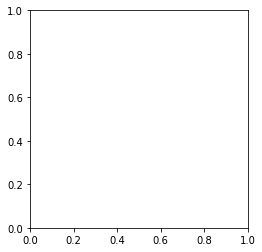

In [33]:

d = 2
n_layers = 8

transforms = []
for _ in range(n_layers):
    transforms.append(T.planar(d))
    transforms.append(T.permute(d, permutation=torch.tensor([1, 0])))
transform_modules = nn.ModuleList([m for m in transforms if isinstance(m, nn.Module)])

base_dist = dist.Normal(0, 1)

def log_prob(x, transforms, base_dist):
    x= x.clone()
    J = 0
    for t in transforms:
#         print(x.shape)
        y = t(x)
        J += t.log_abs_det_jacobian(x, y)
        x = y
        
    log_prob = base_dist.log_prob(x).sum(-1) + J
    return log_prob, y

batch_size = 4
steps = 8192
optimizer = torch.optim.Adam(transform_modules.parameters(), lr=1e-2)
for step in range(steps+1):
    optimizer.zero_grad()
    
    batch = dataset_2d[torch.randperm(len(dataset_2d))][:batch_size]
#     print(dataset_2d.shape)
#     lp, y = log_prob(batch, transforms, base_dist)
    lp, y = log_prob(batch.view(-1, 2), transforms, base_dist)
    lp = lp.view(batch.shape[:-1])
    
    lp = torch.logsumexp(lp, dim=-1) - math.log(lp.shape[-1])    

    loss = -lp.mean()
#     loss = -log_prob(flow_dist, dataset_2d).mean()
    loss.backward()
    optimizer.step()
    
    
    
    if step % 8 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        with torch.no_grad():
            x = torch.linspace(-5, 5, 128)
            xx, yy = torch.meshgrid(x, x, indexing='xy')
            grid = torch.stack([xx, yy]).view(d, -1).permute(1, 0)
            lp, y = log_prob(grid, transforms, base_dist)
            p = lp.exp().view(128, 128)
            p[range(128), range(128)] = p.max()
            plt.imshow(p, extent=(-5, 5, -5, 5), origin='lower')
            plt.ylabel('m1')
            plt.xlabel('m2')
            plt.show()
#             data = pd.DataFrame(data={'x':xx.flatten().numpy().round(2), 'y':yy.flatten().numpy().round(2), 'z':p.numpy()})
#             data = data.pivot(index='x', columns='y', values='z')
#             sns.heatmap(data)
#             plt.show()
            
#             plt.plot(p.sum(0))
#             plt.show()
#             plt.plot(p.sum(1))
#             plt.show()




<AxesSubplot:>

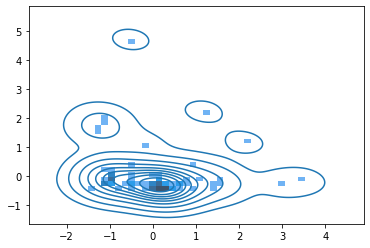

In [7]:
# dataset_2d = torch.cat([torch.randn(64), torch.randn(8) + 6])
# dataset_2d = torch.stack([dataset_2d, dataset_2d + torch.randn_like(dataset_2d)], dim=-1)

dataset = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')
q = dataset['m1'] / dataset['m2']
dataset_2d = torch.stack([torch.tensor(dataset['m1']), torch.tensor(q)], dim=-1).float()

dataset_2d = (dataset_2d - dataset_2d.mean(dim=(0, 1), keepdim=True)) / dataset_2d.std(dim=(0, 1), keepdim=True)

sns.histplot(x=dataset_2d.mean(1)[:, 0], y=dataset_2d.mean(1)[:, 1], bins=32)
sns.kdeplot(x=dataset_2d.mean(1)[:, 0], y=dataset_2d.mean(1)[:, 1])





step: 0, loss: 4.799105644226074


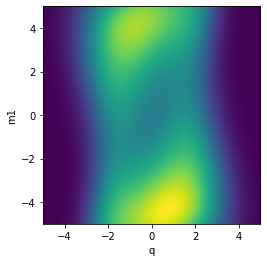

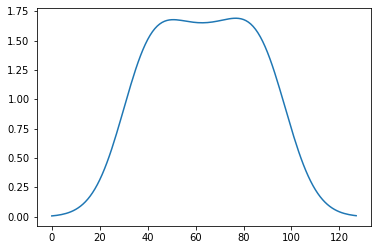

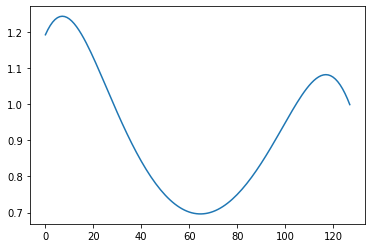

step: 8, loss: 3.9185211658477783


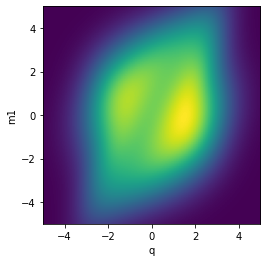

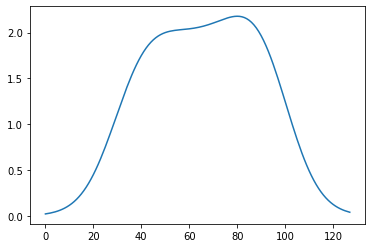

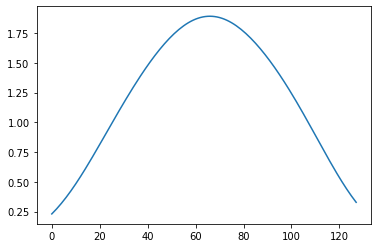

step: 16, loss: 3.345149278640747


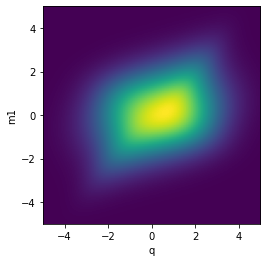

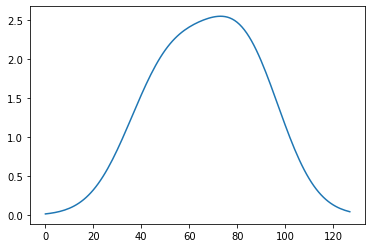

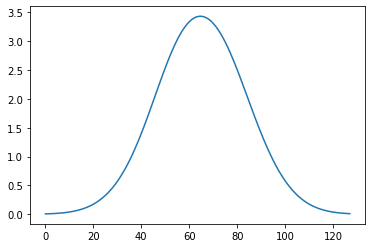

step: 24, loss: 2.5304980278015137


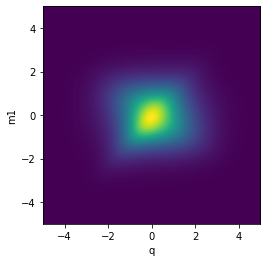

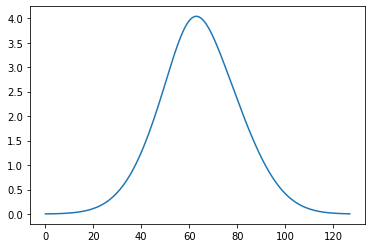

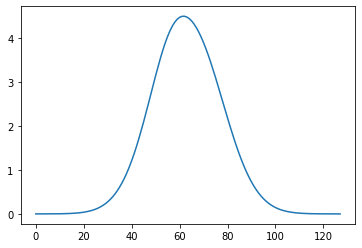

step: 32, loss: 2.4507110118865967


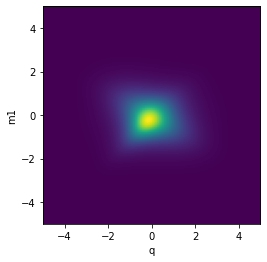

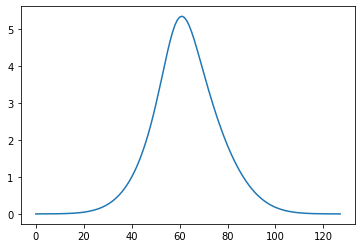

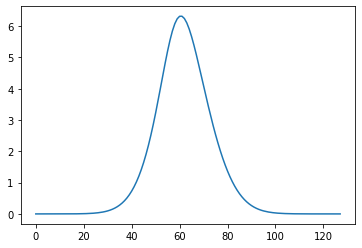

step: 40, loss: 1.3226830959320068


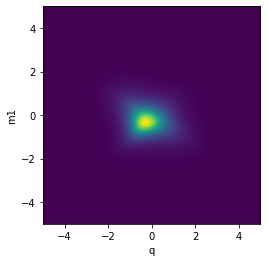

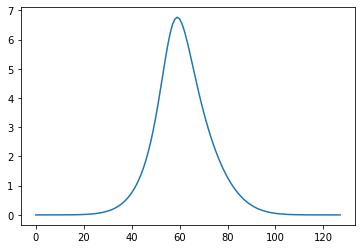

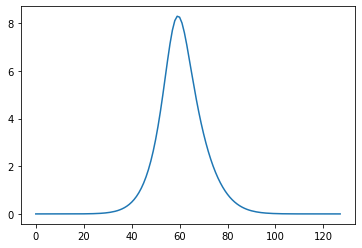

step: 48, loss: 1.8459765911102295


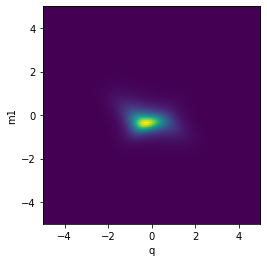

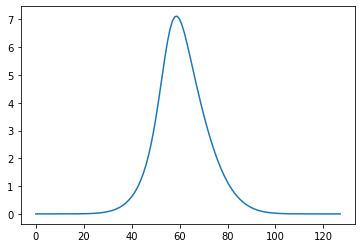

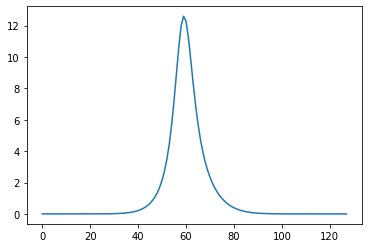

step: 56, loss: 1.9452691078186035


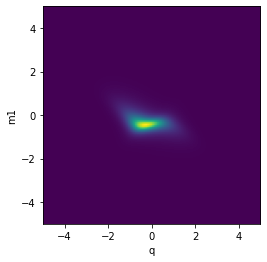

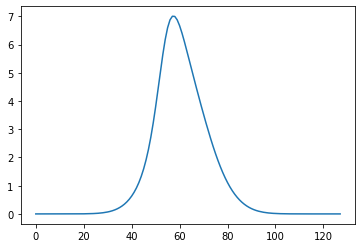

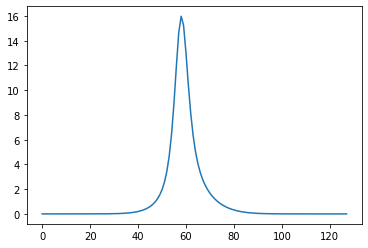

step: 64, loss: 1.2763185501098633


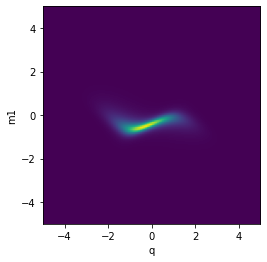

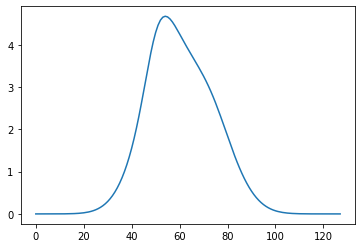

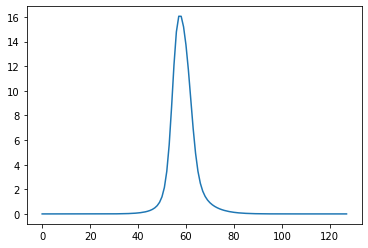

step: 72, loss: 1.8821710348129272


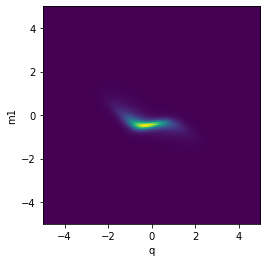

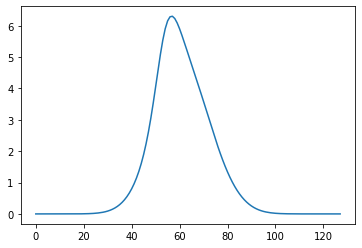

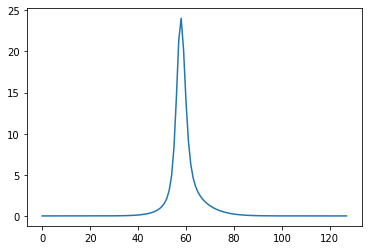

step: 80, loss: 0.6387825012207031


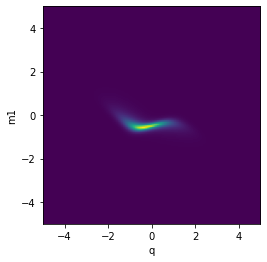

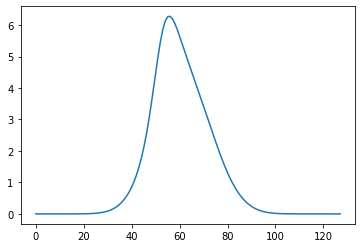

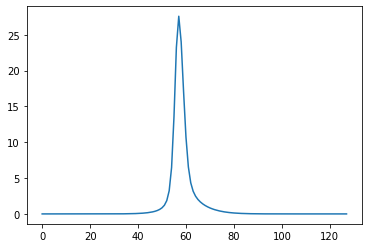

step: 88, loss: 1.4161150455474854


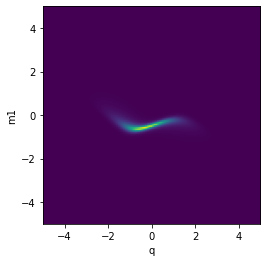

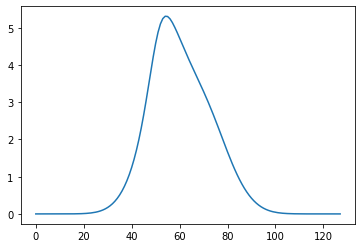

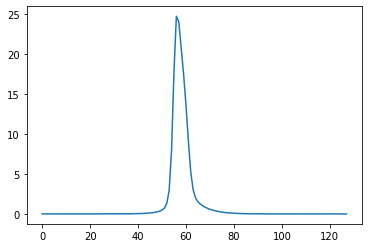

step: 96, loss: 0.4387085437774658


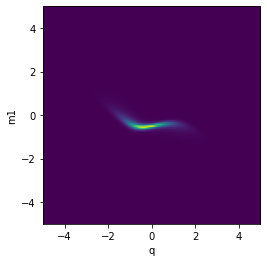

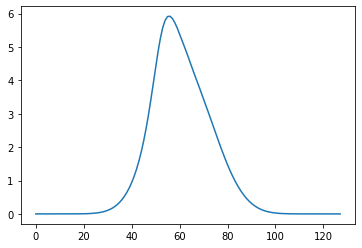

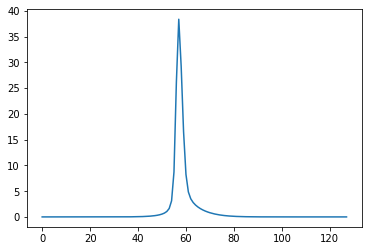

step: 104, loss: 2.337341547012329


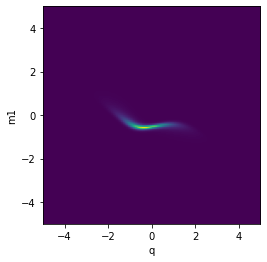

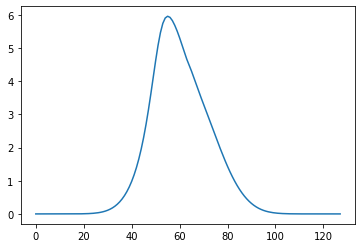

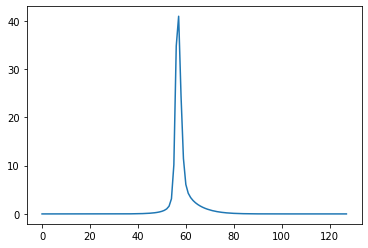

step: 112, loss: 0.9901533126831055


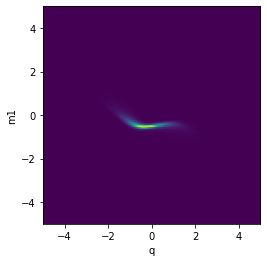

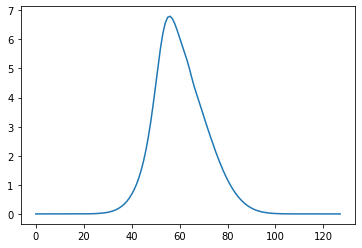

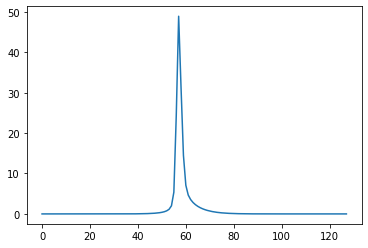

step: 120, loss: 1.4898512363433838


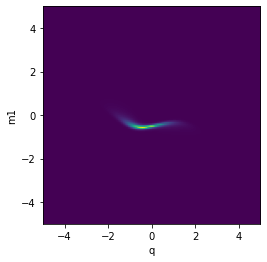

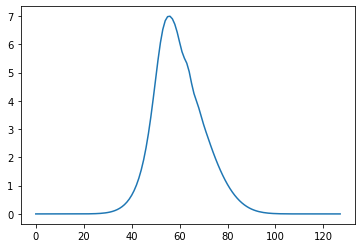

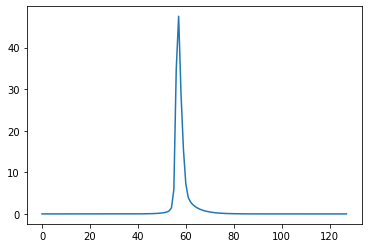

step: 128, loss: 1.0592806339263916


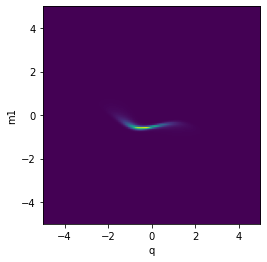

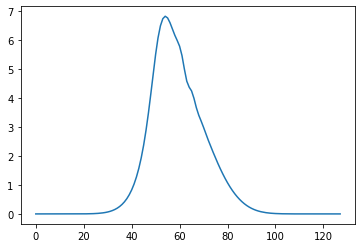

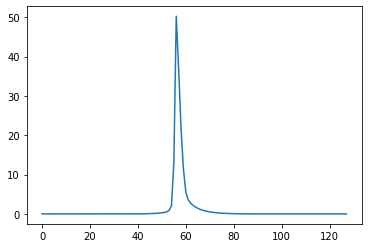

step: 136, loss: 0.4886796474456787


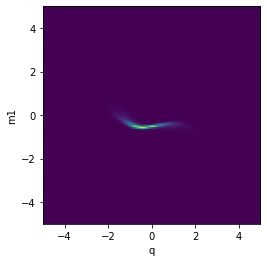

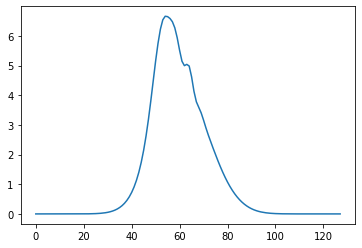

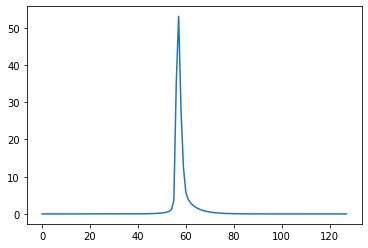

step: 144, loss: 0.25446033477783203


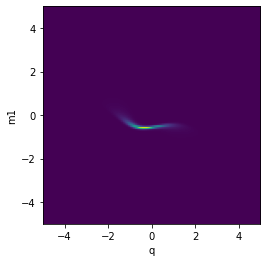

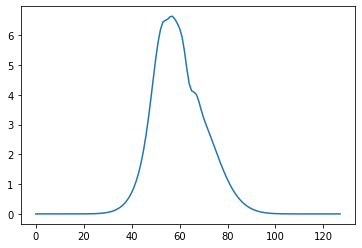

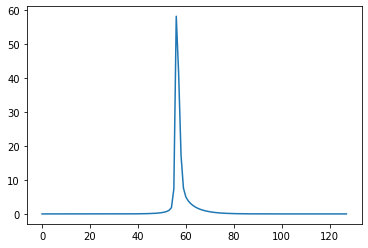

step: 152, loss: 0.9739477634429932


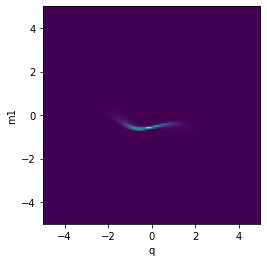

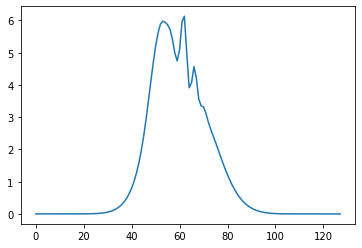

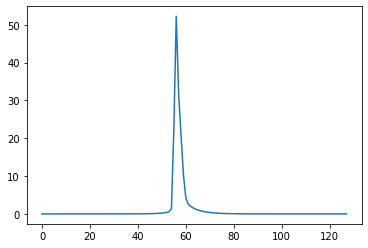

step: 160, loss: 0.8762959241867065


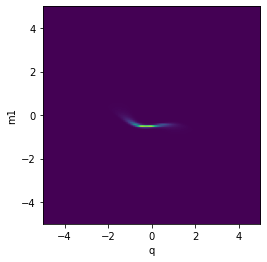

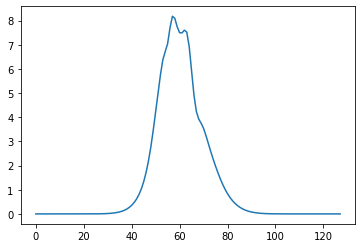

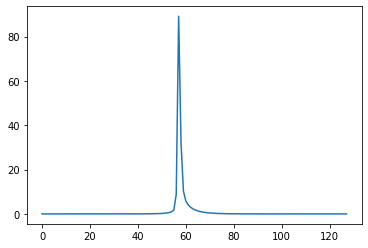

step: 168, loss: 0.932641863822937


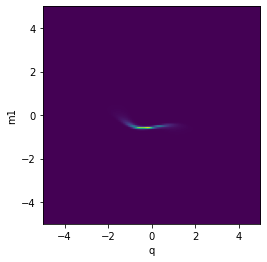

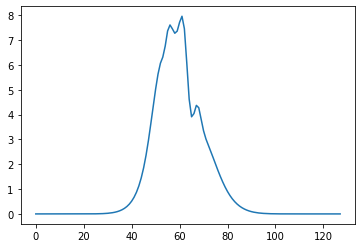

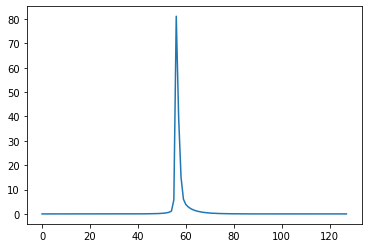

step: 176, loss: 0.705146074295044


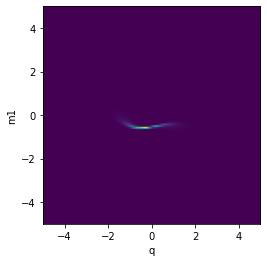

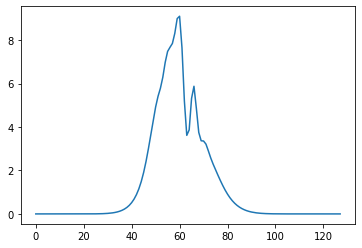

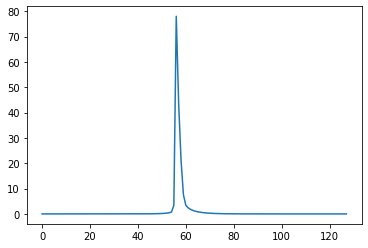

step: 184, loss: 1.0475218296051025


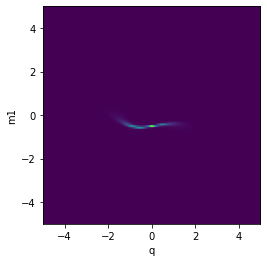

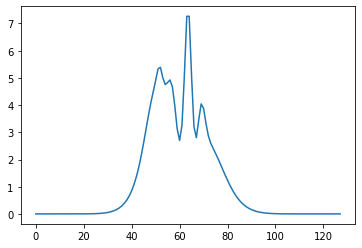

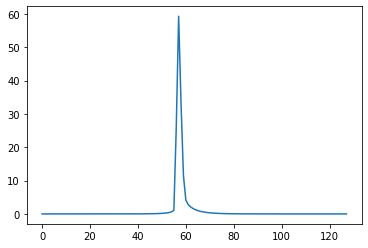

step: 192, loss: 1.4980733394622803


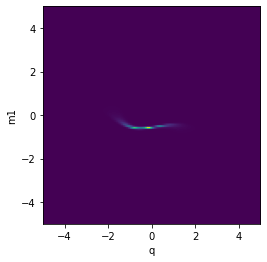

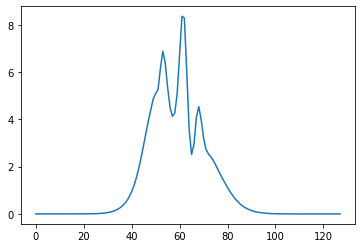

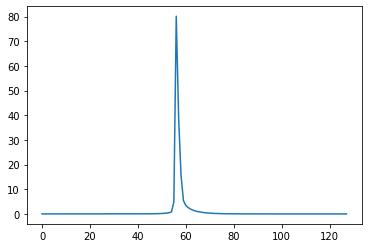

step: 200, loss: 0.08685898780822754


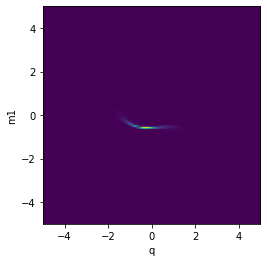

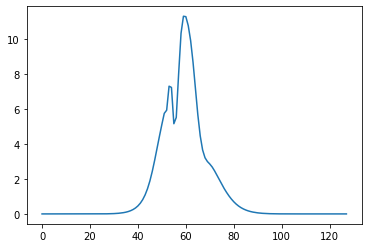

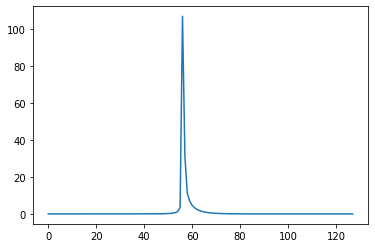

step: 208, loss: 6.44611930847168


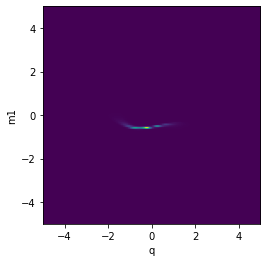

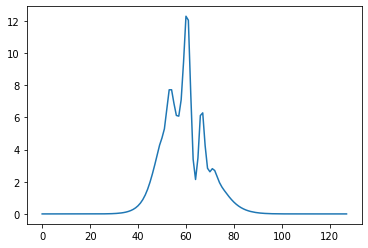

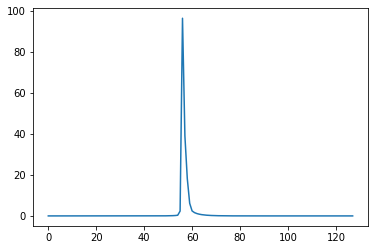

step: 216, loss: -0.24485039710998535


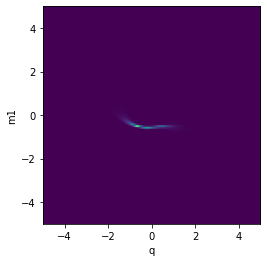

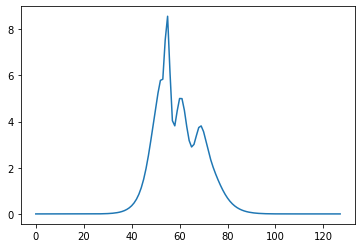

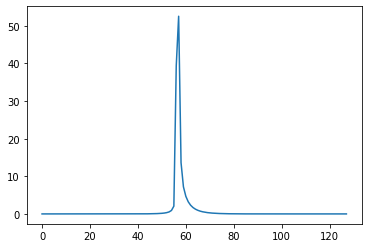

step: 224, loss: 1.4743980169296265


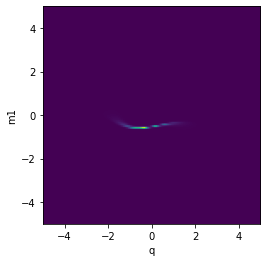

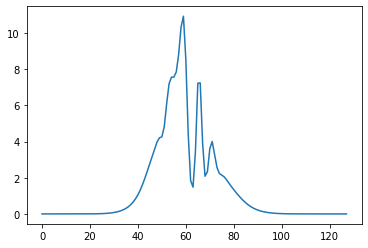

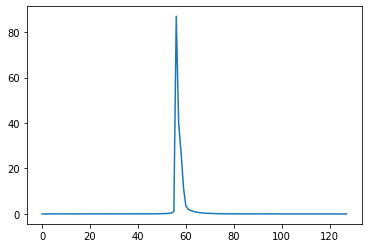

step: 232, loss: 0.5005841255187988


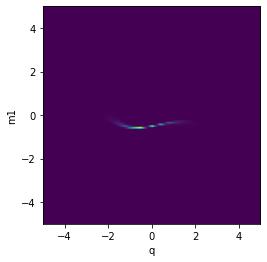

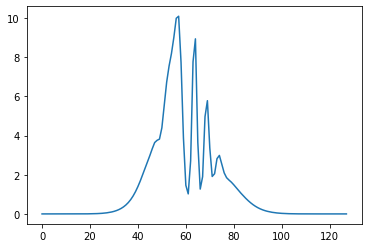

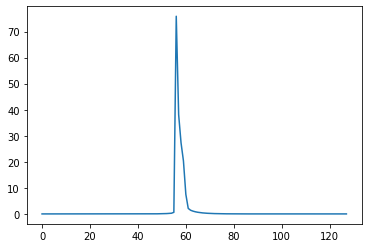

step: 240, loss: 0.5101113319396973


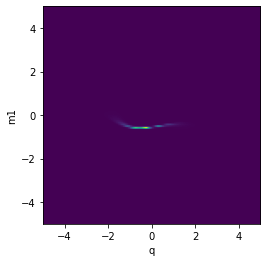

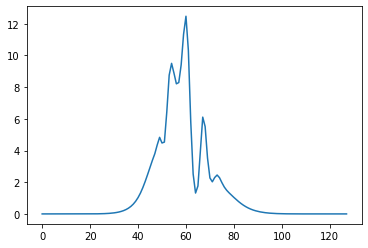

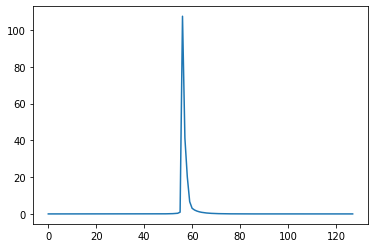

step: 248, loss: 0.46459484100341797


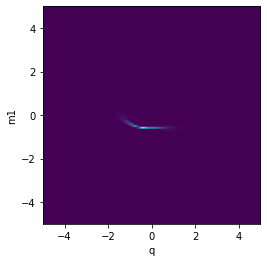

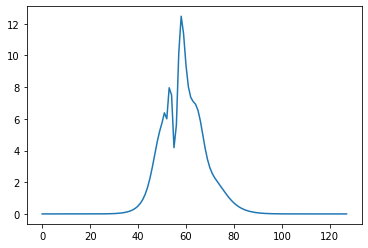

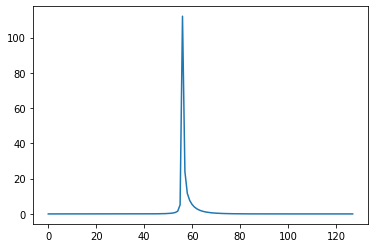

step: 256, loss: 0.5418126583099365


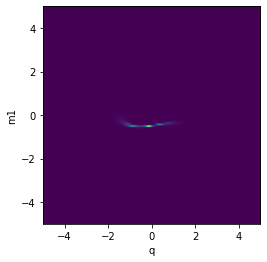

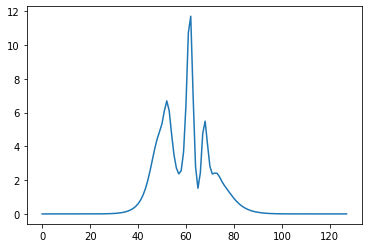

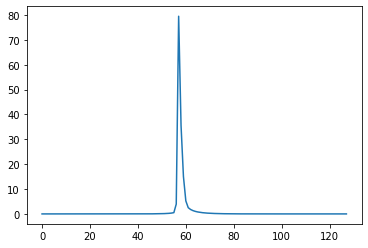

step: 264, loss: 1.0481219291687012


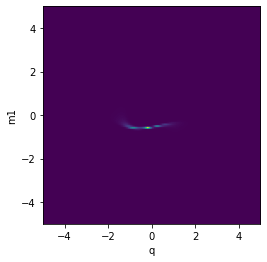

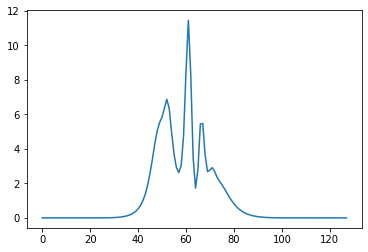

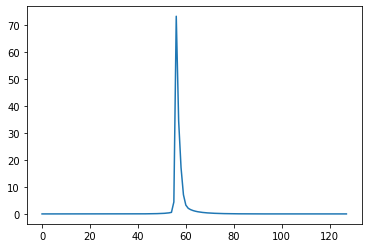

step: 272, loss: 0.41182637214660645


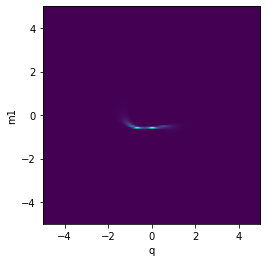

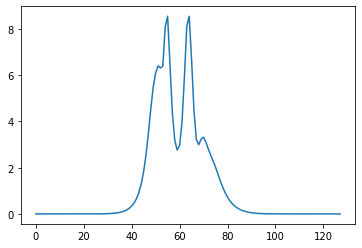

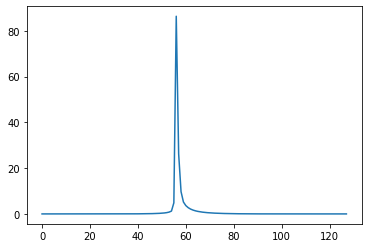

KeyboardInterrupt: 

In [8]:

d = 2
n_layers = 12

transforms = []
for _ in range(n_layers):
    transforms.append(T.planar(d))
    transforms.append(T.permute(d, permutation=torch.tensor([1, 0])))
transform_modules = nn.ModuleList([m for m in transforms if isinstance(m, nn.Module)])

base_dist = dist.Normal(0, 1)

def log_prob(x, transforms, base_dist):
    x= x.clone()
    J = 0
    for t in transforms:
#         print(x.shape)
        y = t(x)
        J += t.log_abs_det_jacobian(x, y)
        x = y
        
    log_prob = base_dist.log_prob(x).sum(-1) + J
    return log_prob, y

batch_size = 4
steps = 8192
optimizer = torch.optim.Adam(transform_modules.parameters(), lr=1e-2)
for step in range(steps+1):
    optimizer.zero_grad()
    
    batch = dataset_2d[torch.randperm(len(dataset_2d))][:batch_size]
#     print(dataset_2d.shape)
#     lp, y = log_prob(batch, transforms, base_dist)
    lp, y = log_prob(batch.view(-1, 2), transforms, base_dist)
    lp = lp.view(batch.shape[:-1])
    
    lp = torch.logsumexp(lp, dim=-1) - math.log(lp.shape[-1])    

    loss = -lp.mean()
#     loss = -log_prob(flow_dist, dataset_2d).mean()
    loss.backward()
    optimizer.step()
    
    
    
    if step % 8 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        with torch.no_grad():
            x = torch.linspace(-5, 5, 128)
            xx, yy = torch.meshgrid(x, x, indexing='xy')
            grid = torch.stack([xx, yy]).view(d, -1).permute(1, 0)
            lp, y = log_prob(grid, transforms, base_dist)
            p = lp.exp().view(128, 128)
#             p[range(128), range(128)] = p.max()
            plt.imshow(p, extent=(-5, 5, -5, 5), origin='lower')
            plt.ylabel('m1')
            plt.xlabel('q')
            plt.show()
#             data = pd.DataFrame(data={'x':xx.flatten().numpy().round(2), 'y':yy.flatten().numpy().round(2), 'z':p.numpy()})
#             data = data.pivot(index='x', columns='y', values='z')
#             sns.heatmap(data)
#             plt.show()
            
            plt.plot(p.sum(0))
            plt.show()
            plt.plot(p.sum(1))
            plt.show()




In [10]:
q.shape

(79, 30000)

<AxesSubplot:ylabel='Density'>

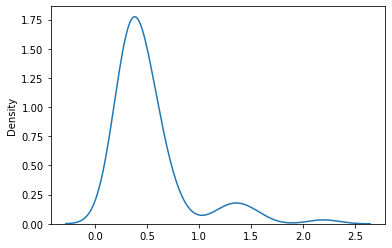

In [15]:
sns.kdeplot(np.log(q).mean(-1))

In [ ]:
q.lo